In [3]:
import pandas as pd
import numpy as np
import ast
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
try:
    df = pd.read_csv('C:/Users/agraw/OneDrive/Desktop/SIH/train.csv', delimiter=',', quotechar='"', on_bad_lines='skip', engine='python')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: train.csv not found.")
    exit()

Dataset loaded successfully.


In [ ]:

print("Columns in the dataset:", df.columns.tolist())
print("First few rows:")
print(df.head())


print("\nData types:")
print(df.dtypes)

expected_columns = ['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID',
                   'TIMESTAMP', 'DAY_TYPE', 'MISSING_DATA', 'POLYLINE']

for col in expected_columns:
    if col not in df.columns:
        print(f"Warning: {col} not found in dataframe")


column_mapping = {}
for col in df.columns:
    if col.upper() in expected_columns:
        column_mapping[col] = col.upper()

df = df.rename(columns=column_mapping)
print("Columns after renaming:", df.columns.tolist())


if 'CALL_TYPE' not in df.columns:
    
    call_type_col = None
    for col in df.columns:
        if 'call' in col.lower() and 'type' in col.lower():
            call_type_col = col
            break
    
    if call_type_col:
        df = df.rename(columns={call_type_col: 'CALL_TYPE'})
        print(f"Renamed {call_type_col} to CALL_TYPE")
    else:
        print("CALL_TYPE column not found. Creating a dummy column.")
        df['CALL_TYPE'] = 'A'  # Default value


if 'DAY_TYPE' not in df.columns:
    day_type_col = None
    for col in df.columns:
        if 'day' in col.lower() and 'type' in col.lower():
            day_type_col = col
            break
    
    if day_type_col:
        df = df.rename(columns={day_type_col: 'DAY_TYPE'})
        print(f"Renamed {day_type_col} to DAY_TYPE")
    else:
        print("DAY_TYPE column not found. Creating a dummy column.")
        df['DAY_TYPE'] = 'A'  # Default value


Columns in the dataset: ['TRIP_ID', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'TIMESTAMP', 'MISSING_DATA', 'POLYLINE', 'duration', 'start_lon', 'start_lat', 'datetime', 'hour', 'day_of_week', 'month', 'CALL_TYPE_B', 'CALL_TYPE_C']
First few rows:
               TRIP_ID  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID   TIMESTAMP  \
0  1372636858620000589         -1.0          -1.0  20000589  1372636858   
1  1372637303620000596         -1.0           7.0  20000596  1372637303   
2  1372636951620000320         -1.0          -1.0  20000320  1372636951   
3  1372636854620000520         -1.0          -1.0  20000520  1372636854   
4  1372637091620000337         -1.0          -1.0  20000337  1372637091   

   MISSING_DATA                                           POLYLINE  duration  \
0         False  [[-8.618643,41.141412],[-8.618499,41.141376],[...       330   
1         False  [[-8.639847,41.159826],[-8.640351,41.159871],[...       270   
2         False  [[-8.612964,41.140359],[-8.613378,41.14035],[

In [ ]:

print("Unique CALL_TYPE values:", df['CALL_TYPE'].unique())
print("Unique DAY_TYPE values:", df['DAY_TYPE'].unique())


Unique CALL_TYPE values: [False  True]
Unique DAY_TYPE values: ['A']


In [20]:
df.shape

(1710660, 17)

In [21]:
df.columns

Index(['TRIP_ID', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'TIMESTAMP',
       'MISSING_DATA', 'POLYLINE', 'duration', 'start_lon', 'start_lat',
       'datetime', 'hour', 'day_of_week', 'month', 'CALL_TYPE', 'CALL_TYPE_C',
       'DAY_TYPE'],
      dtype='object')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1710660 entries, 0 to 1710669
Data columns (total 17 columns):
 #   Column        Dtype         
---  ------        -----         
 0   TRIP_ID       int64         
 1   ORIGIN_CALL   float64       
 2   ORIGIN_STAND  float64       
 3   TAXI_ID       int64         
 4   TIMESTAMP     int64         
 5   MISSING_DATA  bool          
 6   POLYLINE      object        
 7   duration      int64         
 8   start_lon     float64       
 9   start_lat     float64       
 10  datetime      datetime64[ns]
 11  hour          int32         
 12  day_of_week   int32         
 13  month         int32         
 14  CALL_TYPE     bool          
 15  CALL_TYPE_C   bool          
 16  DAY_TYPE      object        
dtypes: bool(3), datetime64[ns](1), float64(4), int32(3), int64(4), object(2)
memory usage: 181.1+ MB


In [23]:
df.describe()

,TRIP_ID,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,duration,start_lon,start_lat,datetime,hour,day_of_week,month
count,1.710660e+06,1.710660e+06,1.710660e+06,1.710660e+06,1.710660e+06,1.710660e+06,1.704759e+06,1.704759e+06,1710660,1.710660e+06,1.710660e+06,1.710660e+06
mean,1.388622e+18,5.221373e+03,1.374490e+01,2.000035e+07,1.388622e+09,7.163705e+02,-8.617260e+00,4.115709e+01,2014-01-02 00:26:43.638314496,1.192222e+01,3.054857e+00,6.586983e+00
min,1.372637e+18,-1.000000e+00,-1.000000e+00,2.000000e+07,1.372637e+09,-1.500000e+01,-3.691378e+01,3.199211e+01,2013-07-01 00:00:53,0.000000e+00,0.000000e+00,1.000000e+00
25%,1.380731e+18,-1.000000e+00,-1.000000e+00,2.000017e+07,1.380731e+09,4.050000e+02,-8.628831e+00,4.114786e+01,2013-10-02 16:15:39.500000,7.000000e+00,1.000000e+00,4.000000e+00
50%,1.388493e+18,-1.000000e+00,-1.000000e+00,2.000034e+07,1.388493e+09,6.000000e+02,-8.612739e+00,4.115436e+01,2013-12-31 12:23:38,1.200000e+01,3.000000e+00,7.000000e+00
75%,1.396750e+18,-1.000000e+00,2.500000e+01,2.000052e+07,1.396750e+09,8.700000e+02,-8.603559e+00,4.116321e+01,2014-04-06 02:14:33.500000,1.700000e+01,5.000000e+00,1.000000e+01
max,1.404173e+18,6.388400e+04,6.300000e+01,2.000098e+07,1.404173e+09,5.820000e+04,5.290080e+01,5.103712e+01,2014-06-30 23:59:56,2.300000e+01,6.000000e+00,1.200000e+01
std,9.180948e+15,1.351846e+04,1.980431e+01,2.112400e+02,9.180948e+06,6.847837e+02,6.065990e-02,2.385531e-02,NaN,6.234560e+00,1.967391e+00,3.412272e+00


In [ ]:
print("Preprocessing data...")
df = df[df['MISSING_DATA'] == False]  # Removing rows with missing data


def calculate_duration(polyline):
    try:
        coords = ast.literal_eval(polyline)
        return (len(coords) - 1) * 15  # Here each segment represents 15 seconds
    except:
        return np.nan

df['duration'] = df['POLYLINE'].apply(calculate_duration)
df = df.dropna(subset=['duration'])

Preprocessing data...


In [ ]:
# Feature engineering
def extract_features(df):
    
    def get_start_point(polyline):
        try:
            coords = ast.literal_eval(polyline)
            return coords[0][0], coords[0][1] if coords else (np.nan, np.nan)
        except:
            return (np.nan, np.nan)
    
    df['start_lon'], df['start_lat'] = zip(*df['POLYLINE'].apply(get_start_point))
    
    
    df['datetime'] = pd.to_datetime(df['TIMESTAMP'], unit='s')
    df['hour'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.dayofweek
    df['month'] = df['datetime'].dt.month
    
    
    call_type_dummies = pd.get_dummies(df['CALL_TYPE'], prefix='CALL_TYPE')
    df = pd.concat([df, call_type_dummies], axis=1)
    
    
    
    day_type_dummies = pd.get_dummies(df['DAY_TYPE'], prefix='DAY_TYPE')
    df = pd.concat([df, day_type_dummies], axis=1)
    
    
    if 'ORIGIN_CALL' in df.columns:
        df['ORIGIN_CALL'] = df['ORIGIN_CALL'].fillna(-1)
    if 'ORIGIN_STAND' in df.columns:
        df['ORIGIN_STAND'] = df['ORIGIN_STAND'].fillna(-1)
    
    return df

df = extract_features(df)

In [ ]:

print("All columns in dataframe:", df.columns.tolist())


base_features = [
    'start_lon', 'start_lat', 'hour', 'day_of_week', 'month'
]


if 'ORIGIN_CALL' in df.columns:
    base_features.append('ORIGIN_CALL')
if 'ORIGIN_STAND' in df.columns:
    base_features.append('ORIGIN_STAND')


call_type_cols = [col for col in df.columns if col.startswith('CALL_TYPE_')]
day_type_cols = [col for col in df.columns if col.startswith('DAY_TYPE_')]

features = base_features + call_type_cols + day_type_cols


available_features = [col for col in features if col in df.columns]
print("Available features:", available_features)

X = df[available_features]
y = df['duration']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

All columns in dataframe: ['TRIP_ID', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TAXI_ID', 'TIMESTAMP', 'MISSING_DATA', 'POLYLINE', 'duration', 'start_lon', 'start_lat', 'datetime', 'hour', 'day_of_week', 'month', 'CALL_TYPE', 'CALL_TYPE_C', 'DAY_TYPE', 'CALL_TYPE_False', 'CALL_TYPE_True', 'DAY_TYPE_A']
Available features: ['start_lon', 'start_lat', 'hour', 'day_of_week', 'month', 'ORIGIN_CALL', 'ORIGIN_STAND', 'CALL_TYPE_C', 'CALL_TYPE_False', 'CALL_TYPE_True', 'DAY_TYPE_A']


Training model...

Model Performance:
MAE: 327.57 seconds (5.46 minutes)
RMSE: 667.09 seconds (11.12 minutes)
MAPE: inf%


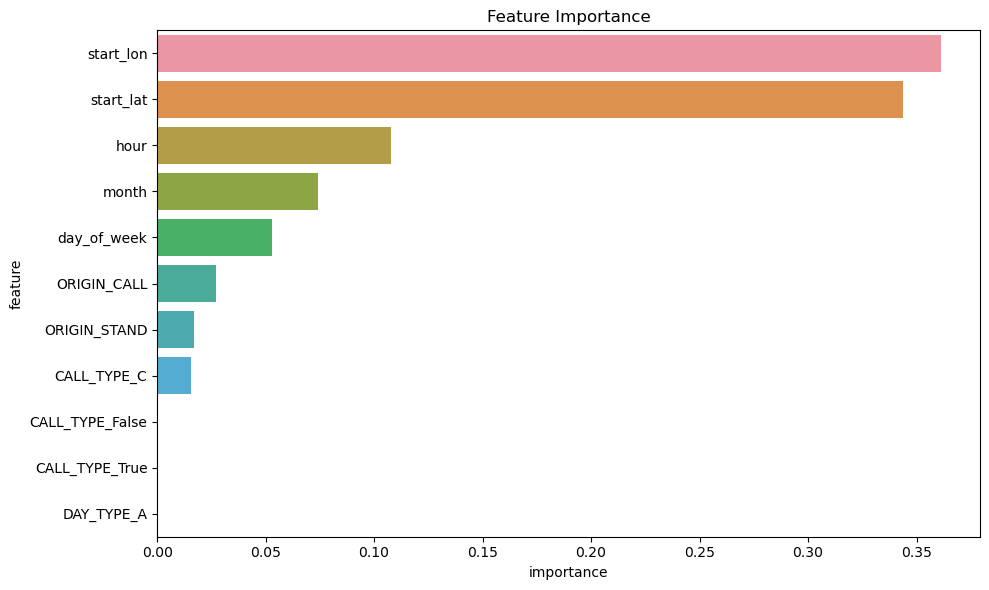

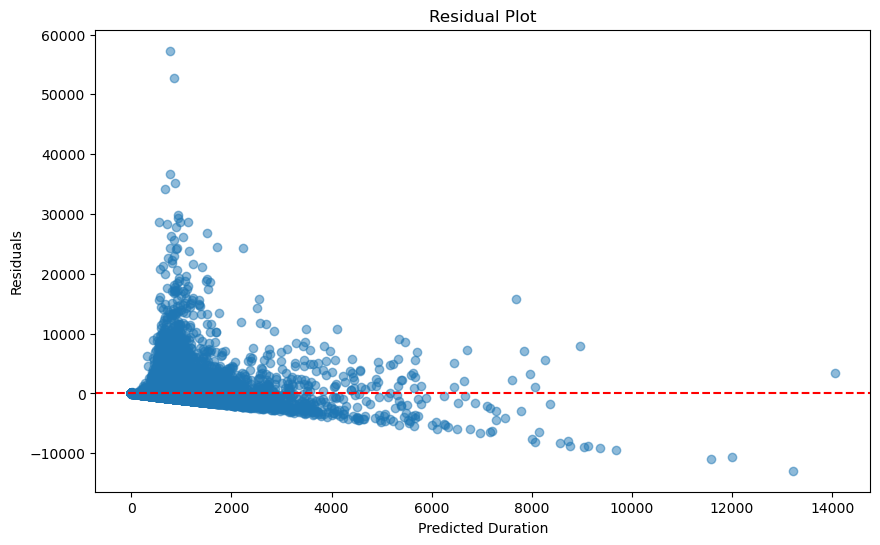

Model training completed successfully!


In [ ]:
# Training model
print("Training model...")
model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

# Evaluation metrics
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return mae, rmse, mape

mae, rmse, mape = calculate_metrics(y_test, y_pred)

print(f"\nModel Performance:")
print(f"MAE: {mae:.2f} seconds ({mae/60:.2f} minutes)")
print(f"RMSE: {rmse:.2f} seconds ({rmse/60:.2f} minutes)")
#print(f"MAPE: {mape:.2f}%")


feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()


residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Duration')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Prediction for new data
def predict_duration(model, input_data):
    """Predict duration for new taxi trip"""
    prediction = model.predict(input_data)
    return prediction[0]

print("Model training completed successfully!")